In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
os.system('pip install segmentation_models_3D')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 6.3 MB/s eta 0:00:00


0

In [3]:
import os
import numpy as np
import keras.backend as K


def load_img(img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(image_name)
            #image = image[56:184, 56:184, 13:141]
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

def imageLoader(img_list, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_list[batch_start:limit])
            Y = load_img(mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [4]:
train_img_dir = "/kaggle/input/brats2023-ssa-dataset-npy/SSA_BRATS2023_split/train/images/"
train_mask_dir = "/kaggle/input/brats2023-ssa-dataset-npy/SSA_BRATS2023_split/train/masks/"

val_img_dir = "/kaggle/input/brats2023-ssa-dataset-npy/SSA_BRATS2023_split/val/images/"
val_mask_dir = "/kaggle/input/brats2023-ssa-dataset-npy/SSA_BRATS2023_split/val/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [5]:
print(len(train_img_list), len(train_mask_list))
print(len(val_img_list), len(val_mask_list))

45 45
15 15


In [6]:
import random
from matplotlib import pyplot as plt

In [7]:
t_images_path = []
t_masks_path = []

for i in train_img_list:
    pth = train_img_dir+i
    t_images_path.append(pth)
    

for i in train_mask_list:
    pth = train_mask_dir+i
    t_masks_path.append(pth)


In [8]:
v_images_path = []
v_masks_path = []

for i in val_img_list:
    pth = val_img_dir+i
    v_images_path.append(pth)

for i in val_mask_list:
    pth = val_mask_dir+i
    v_masks_path.append(pth)
    

In [9]:
batch_size = 2

train_img_datagen = imageLoader(t_images_path, 
                                t_masks_path, batch_size)

val_img_datagen = imageLoader(v_images_path, 
                                 v_masks_path, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

In [10]:
test_img.shape


(128, 128, 128, 4)

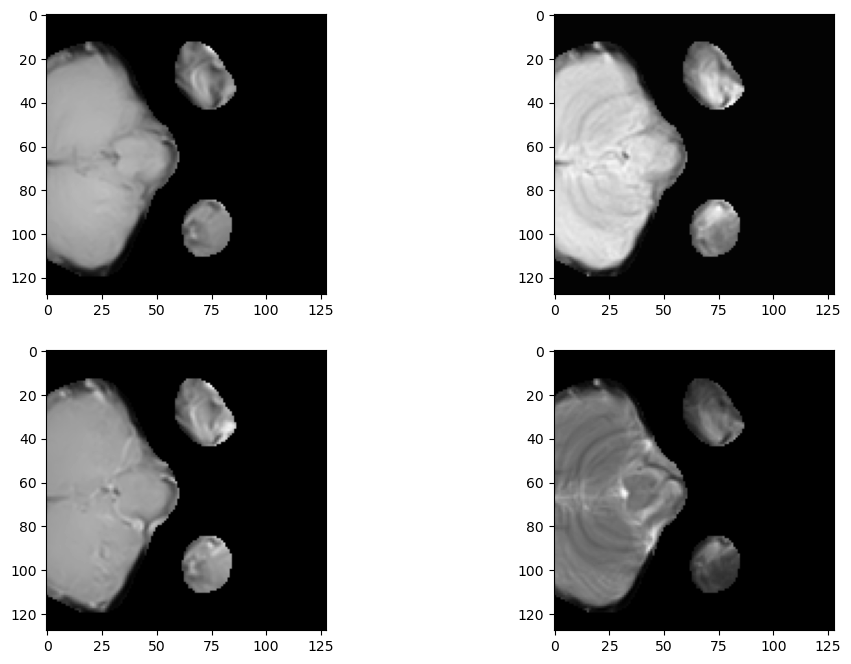

In [13]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')

plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')

plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')

plt.subplot(224)
plt.imshow(test_img[:,:,n_slice, 3], cmap='gray')

plt.show()

Text(0.5, 1.0, 'Mask')

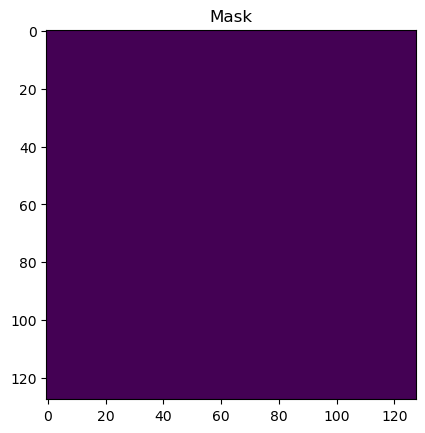

In [14]:
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

In [15]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [16]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, UpSampling3D, Multiply, Add

def attention_block(input_tensor, gating_signal):
    g_conv = Conv3D(filters=input_tensor.shape[-1], kernel_size=(1, 1, 1), padding='same')(gating_signal)
    combined = Add()([g_conv, input_tensor])
    attention = Conv3D(filters=1, kernel_size=(1, 1, 1), activation='sigmoid', padding='same')(combined)
    multiplied = Multiply()([attention, input_tensor])
    return multiplied

def unet_3d_with_attention(input_shape, num_classes):
    inputs = Input(input_shape)
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same', name='conv1')(s)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', name='conv2')(p1)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv3')(p2)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv4')(p3)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv5')(p4)
    p5 = MaxPooling3D(pool_size=(2, 2, 2))(c5)
    
    # Bottleneck with attention
    b = Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='bottleneck')(p5)
    b_attention = attention_block(b, p5)
    
    # Expanding path
    u6 = UpSampling3D(size=(2, 2, 2))(b_attention)
    u6 = UpSampling3D(size=(2, 2, 2))(u6)
    u6 = Conv3D(128, (1, 1, 1), activation='relu', padding='same')(u6)  # Add 1x1x1 convolution
    c4_1x1 = Conv3D(128, (1, 1, 1), activation='relu', padding='same')(c4)  # Add 1x1x1 convolution
    u6 = concatenate([u6, c4_1x1], axis=-1)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv6')(u6)
     
    u7 = UpSampling3D(size=(2, 2, 2))(c6)
    c3_1x1 = Conv3D(64, (1, 1, 1), activation='relu', padding='same')(c3)  # Add 1x1x1 convolution
    u7 = concatenate([u7, c3_1x1], axis=-1)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv7')(u7)
     
    u8 = UpSampling3D(size=(2, 2, 2))(c7)
    c2_1x1 = Conv3D(32, (1, 1, 1), activation='relu', padding='same')(c2)  # Add 1x1x1 convolution
    u8 = concatenate([u8, c2_1x1], axis=-1)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', name='conv8')(u8)
     
    u9 = UpSampling3D(size=(2, 2, 2))(c8)
    c1_1x1 = Conv3D(16, (1, 1, 1), activation='relu', padding='same')(c1)  # Add 1x1x1 convolution
    u9 = concatenate([u9, c1_1x1], axis=-1)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', padding='same', name='conv9')(u9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax', name='output')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Usage
input_shape = (128, 128, 128, 4)  # Adjust dimensions and channels as needed
num_classes = 4  # Number of segmentation classes
model = unet_3d_with_attention(input_shape, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv1 (Conv3D)                 (None, 128, 128, 12  1744        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 64, 64, 64,   0           ['conv1[0][0]']                  
                                16)                                                           

In [17]:
###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import keras
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [18]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanIoU


import tensorflow as tf
#Test if everything is working ok. 
model = unet_3d_with_attention(input_shape, num_classes)
print(model.input_shape)
print(model.output_shape)

#######################################################################
#Fit the model 

steps_per_epoch = len(t_images_path)//batch_size
val_steps_per_epoch = len(v_images_path)//batch_size


# Compile the model
optimizer = Adam(lr=1e-4)


metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
           dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
           dice_coef_edema ,dice_coef_enhancing]

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = metrics )


(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
callbacks = [
    #keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                              #patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                           patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='model_{epoch:02d}-{dice_coef:.6f}.h5',
                                    verbose=1, save_best_only=True, save_weights_only=False)


        
     ]

In [21]:
import pickle

# ... (your code for training and history definition)

history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    callbacks = callbacks,
                    validation_steps=val_steps_per_epoch,
                    )

model.save('brats_3d_50.hdf5')

# Save the history object as a pickle file
pickle_file = 'history.pkl'
with open(pickle_file, 'wb') as file:
    pickle.dump(history.history, file)

print(f"History saved as {pickle_file}")


Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 10.6988 - accuracy: 0.8924 - mean_io_u: 0.7670 - dice_coef: 0.3274 - precision: 0.8926 - sensitivity: 0.8915 - specificity: 0.9642 - dice_coef_necrotic: 0.1055 - dice_coef_edema: 0.1770 - dice_coef_enhancing: 0.0108
Epoch 1: val_loss improved from 3.94738 to 3.08144, saving model to model_01-0.327449.h5
22/22 [==============================] - 18s 808ms/step - loss: 10.6988 - accuracy: 0.8924 - mean_io_u: 0.7670 - dice_coef: 0.3274 - precision: 0.8926 - sensitivity: 0.8915 - specificity: 0.9642 - dice_coef_necrotic: 0.1055 - dice_coef_edema: 0.1770 - dice_coef_enhancing: 0.0108 - val_loss: 3.0814 - val_accuracy: 0.9105 - val_mean_io_u: 0.6851 - val_dice_coef: 0.3497 - val_precision: 0.9109 - val_sensitivity: 0.9083 - val_specificity: 0.9704 - val_dice_coef_necrotic: 0.2241 - val_dice_coef_edema: 0.2249 - val_dice_coef_enhancing: 0.0018 - lr: 1.0000e-04
Epoch 2/100
22/22 [==============================] - ETA: 0s - los

In [22]:
import pickle

# Load history from pickle file
with open('history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Now you can use loaded_history as you would with the original history object
#print(loaded_history)


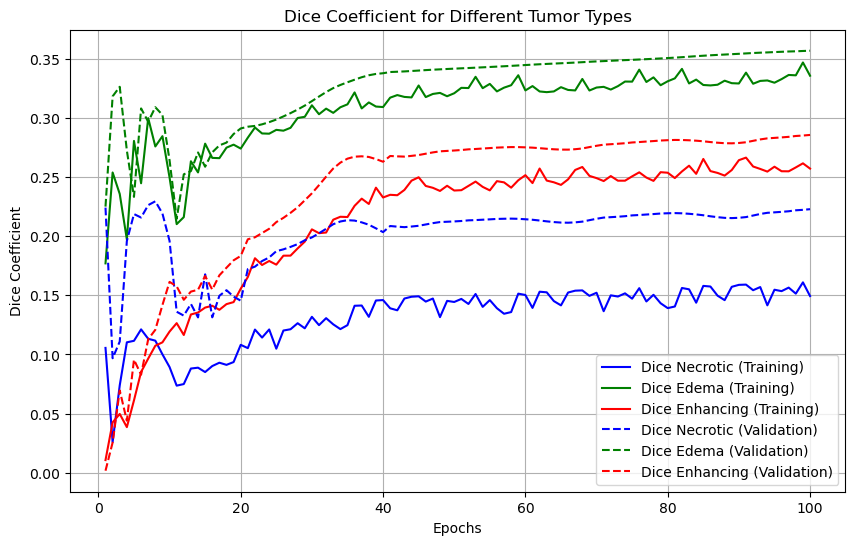

In [23]:
import matplotlib.pyplot as plt

# Extract relevant metrics from the history
dice_coef_necrotic = history.history['dice_coef_necrotic']
dice_coef_edema = history.history['dice_coef_edema']
dice_coef_enhancing = history.history['dice_coef_enhancing']
val_dice_coef_necrotic = history.history['val_dice_coef_necrotic']
val_dice_coef_edema = history.history['val_dice_coef_edema']
val_dice_coef_enhancing = history.history['val_dice_coef_enhancing']

epochs = range(1, len(dice_coef_necrotic) + 1)

# Plotting dice coefficient for different tumor types
plt.figure(figsize=(10, 6))

plt.plot(epochs, dice_coef_necrotic, 'b', label='Dice Necrotic (Training)')
plt.plot(epochs, dice_coef_edema, 'g', label='Dice Edema (Training)')
plt.plot(epochs, dice_coef_enhancing, 'r', label='Dice Enhancing (Training)')

plt.plot(epochs, val_dice_coef_necrotic, 'b--', label='Dice Necrotic (Validation)')
plt.plot(epochs, val_dice_coef_edema, 'g--', label='Dice Edema (Validation)')
plt.plot(epochs, val_dice_coef_enhancing, 'r--', label='Dice Enhancing (Validation)')

plt.title('Dice Coefficient for Different Tumor Types')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()

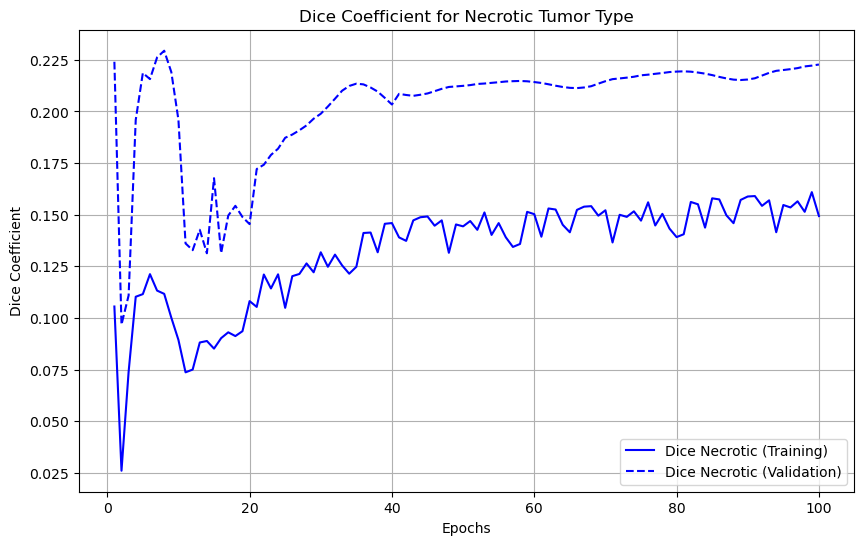

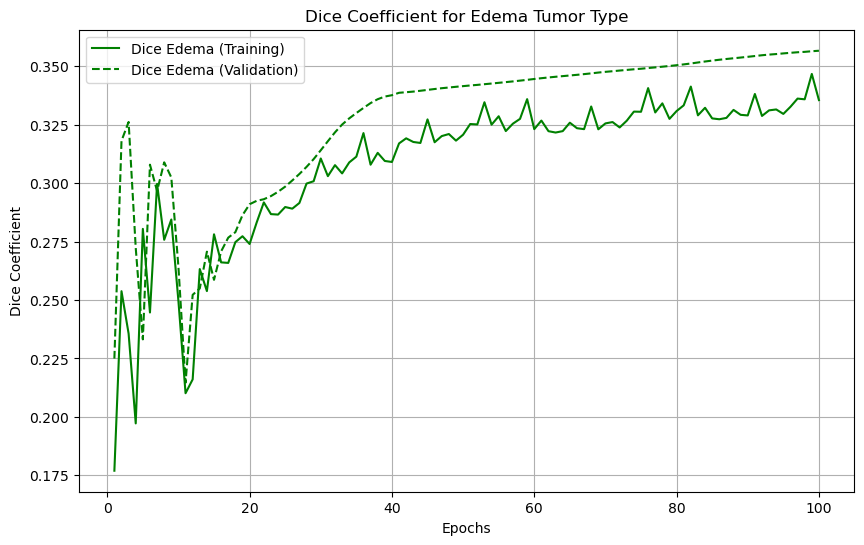

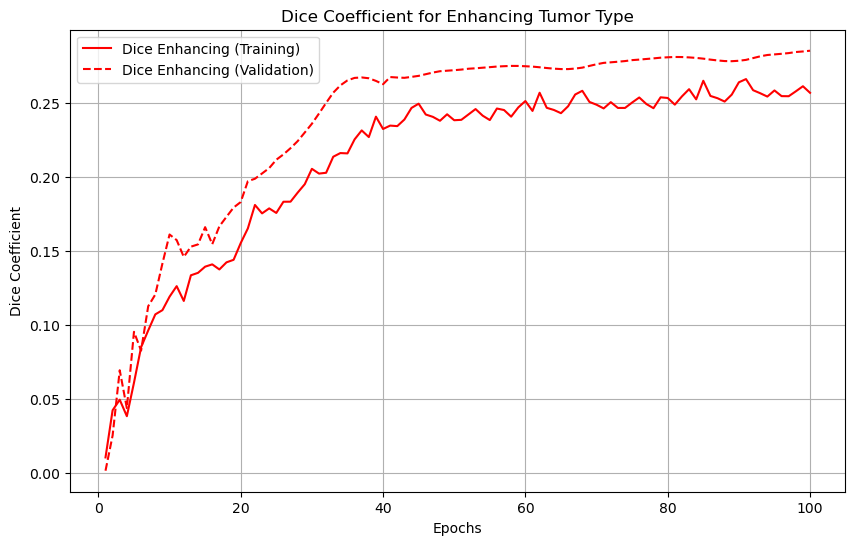

In [24]:
import matplotlib.pyplot as plt

# Extract relevant metrics from the history
dice_coef_necrotic = history.history['dice_coef_necrotic']
dice_coef_edema = history.history['dice_coef_edema']
dice_coef_enhancing = history.history['dice_coef_enhancing']
val_dice_coef_necrotic = history.history['val_dice_coef_necrotic']
val_dice_coef_edema = history.history['val_dice_coef_edema']
val_dice_coef_enhancing = history.history['val_dice_coef_enhancing']

epochs = range(1, len(dice_coef_necrotic) + 1)

# Plotting dice coefficient for Necrotic class
plt.figure(figsize=(10, 6))

plt.plot(epochs, dice_coef_necrotic, 'b', label='Dice Necrotic (Training)')
plt.plot(epochs, val_dice_coef_necrotic, 'b--', label='Dice Necrotic (Validation)')

plt.title('Dice Coefficient for Necrotic Tumor Type')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()

# Plotting dice coefficient for Edema class
plt.figure(figsize=(10, 6))

plt.plot(epochs, dice_coef_edema, 'g', label='Dice Edema (Training)')
plt.plot(epochs, val_dice_coef_edema, 'g--', label='Dice Edema (Validation)')

plt.title('Dice Coefficient for Edema Tumor Type')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()

# Plotting dice coefficient for Enhancing class
plt.figure(figsize=(10, 6))

plt.plot(epochs, dice_coef_enhancing, 'r', label='Dice Enhancing (Training)')
plt.plot(epochs, val_dice_coef_enhancing, 'r--', label='Dice Enhancing (Validation)')

plt.title('Dice Coefficient for Enhancing Tumor Type')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
############ load trained model ################
import tensorflow as tf

model = keras.models.load_model('/kaggle/working/model_02-0.756685.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
# Assuming you have loaded the model as shown in your code
import numpy as np

# Load your test data, preprocess if necessary
test_img = np.load("/kaggle/input/brats2023-ssa-dataset-npy/SSA_BRATS2023_split/val/images/image_22.npy")

# Expand dimensions to match model input shape
test_img_input = np.expand_dims(test_img, axis=0)

# Perform prediction using the loaded model
predictions = model.predict(test_img_input)

# Assuming you have 4 classes in your segmentation
num_classes = 4

# Get the predicted class labels by selecting the class with the highest probability
predicted_labels = np.argmax(predictions, axis=-1)

# Now you can visualize the predicted labels or use them for further analysis
# For example, you can display one of the slices from the predicted label
import matplotlib.pyplot as plt

n_slice = 55  # Choose the slice you want to visualize

plt.imshow(predicted_labels[0, :, :, n_slice], cmap='jet')
plt.title("Predicted Label")
plt.show()
